In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels as stats
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import seaborn as sns

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
data = pd.read_excel("Downloads/Final_RA_data.xlsx")

### Missing Value Imputation

### Creating df_imp by imputing missing values using the following technique-
#### Values for each colum are Linearly interpolating  at Company level
#### Some missing values still remain because linear interpolation does not work when entire column is NaN. So, the remaining missing values are replaced with the Column Mean*. 

#### NOTE- The Column Mean is calculated taking the entire column into account and not at Company level

In [59]:
df=data[['Companies','sgna','fyear','current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','gross_profit','Litigation', 'Numbers', 'developed', 'Multinational', 'Australia', 'Belgium', 'Germany', 'India', 'Ireland', 'Norway', 'Singapore', 'Sweden', 'UK', 'USA', 
      'policy_reforms_australia', 'policy_reforms_germany', 'policy_reforms_india', 'policy_reforms_NORWAY', 'policy_reforms_SINGAPORE', 'policy_reforms_SWEDEN','policy_reforms_UK',
      'policy_reforms_usa', 'GDP per capita growth (annual %)', 'Life expectancy at birth, total (years)', 'Mortality rate, infant (per 1,000 live births)', 
      'Population, total', 'Individuals using the Internet (% of population)', 'Physicians (per 1,000 people)','acquisitions']]
print("Shape of Data:", df.shape)
df.isnull().sum()

Shape of Data: (3158, 40)


Companies                                              0
sgna                                                1011
fyear                                                  0
current_assets                                       305
age                                                    1
ppe                                                  835
emp                                                 1153
operating_expenses                                   369
liabilities                                          656
book_value                                          1022
gross_profit                                         463
Litigation                                             1
Numbers                                                0
developed                                              0
Multinational                                        569
Australia                                              0
Belgium                                                0
Germany                        

#### Linear Interpolation of  Missing Values

In [60]:
df = df.groupby("Companies").transform(lambda x: x.interpolate(limit_direction='both'))
df['Companies'] =  data['Companies']
print("--------------------------------------------------")
print("Missing values left out after Linear Interpolation")
print(df.isnull().sum())

--------------------------------------------------
Missing values left out after Linear Interpolation
sgna                                                 584
fyear                                                  0
current_assets                                        73
age                                                    0
ppe                                                  638
emp                                                  782
operating_expenses                                   207
liabilities                                          570
book_value                                           874
gross_profit                                         297
Litigation                                             0
Numbers                                                0
developed                                              0
Multinational                                        460
Australia                                              0
Belgium                                    

#### Replacing remaining missing Values with Column Mean

In [61]:
df['liabilities'] = df['liabilities'].transform(lambda x: x.fillna(x.mean()))
df['current_assets'] = df['current_assets'].transform(lambda x: x.fillna(x.mean()))
df['ppe'] = df['ppe'].transform(lambda x: x.fillna(x.mean()))
df['operating_expenses'] = df['operating_expenses'].transform(lambda x: x.fillna(x.mean()))
df['emp'] = df['emp'].transform(lambda x: x.fillna(x.mean()))
df['book_value'] = df['book_value'].transform(lambda x: x.fillna(x.mean()))
df['gross_profit'] = df['gross_profit'].transform(lambda x: x.fillna(x.mean()))
df['sgna'] = df['sgna'].transform(lambda x: x.fillna(x.mean()))
df['Multinational'] = df['Multinational'].transform(lambda x: x.fillna(x.mean()))
df['GDP per capita growth (annual %)'] = df['GDP per capita growth (annual %)'].transform(lambda x: x.fillna(x.mean()))
df['Life expectancy at birth, total (years)'] = df['Life expectancy at birth, total (years)'].transform(lambda x: x.fillna(x.mean()))
df['Mortality rate, infant (per 1,000 live births)'] = df['Mortality rate, infant (per 1,000 live births)'].transform(lambda x: x.fillna(x.mean()))
df['Population, total'] = df['Population, total'].transform(lambda x: x.fillna(x.mean()))
df['Individuals using the Internet (% of population)'] = df['Individuals using the Internet (% of population)'].transform(lambda x: x.fillna(x.mean()))
df['Physicians (per 1,000 people)'] = df['Physicians (per 1,000 people)'].transform(lambda x: x.fillna(x.mean()))
df['acquisitions'] = df['acquisitions'].transform(lambda x: x.fillna(x.mean()))

In [62]:
print(df.isnull().sum())

sgna                                                0
fyear                                               0
current_assets                                      0
age                                                 0
ppe                                                 0
emp                                                 0
operating_expenses                                  0
liabilities                                         0
book_value                                          0
gross_profit                                        0
Litigation                                          0
Numbers                                             0
developed                                           0
Multinational                                       0
Australia                                           0
Belgium                                             0
Germany                                             0
India                                               0
Ireland                     

### Variable Creation

##### Create a quadratic term for SGNA (SQ_SGNA)

In [63]:
df['SQ_SGNA'] = (df['sgna'])**2

### Find the lag of SGNA at the company and fyear level
Selection of optimal lag at Company and fyear level -

I looked at the acf plots for each company and fyear level and found that lags 1 and 2 have the significant correlation with the presnt sgna as shown below-

In order to to get the optimal lag for every company, I have fit an OLS model to predict sgna from it's lag. I have compared the Information Criterion - AIC for lag 1, 2 and 3 and chosen the lag with the lowest AIC as the optimal lag

#### Function to find the optimal lag for every Company at fyear level

In [64]:
import statsmodels.api as sm
aic_dict = {}
df_lag=pd.DataFrame()
def get_optimal_lag(company_name):
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(1)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag1'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(2)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag2'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(3)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag3'] = model.aic  
    return min(aic_dict, key=aic_dict.get)

#### Dictionary to store the Company and its corresponding optimal lag - optimal_lag_dict

In [65]:
optimal_lag_dict = {}
for i in set(df['Companies']):
    #optimal_lag_list.append(get_optimal_lag(i))
    optimal_lag_dict[i] = get_optimal_lag(i)    

#### Setting lag for every company using the optimal_lag_dict

In [66]:
for i in set(df['Companies']):
    if(optimal_lag_dict[i]=='lag1'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(1)
    if(optimal_lag_dict[i]=='lag2'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(2)
    if(optimal_lag_dict[i]=='lag3'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(3)   

#### Creating SGNA_MKT varables for by finding the moving average of SGNA for each firm for 3 years

In [67]:
for i in set(df['Companies']):
    df.loc[df.Companies==i,'sgna_mkt']=df[df.Companies==i].sgna.rolling(window=3).mean()

#### Removing rows with missing lag_sgna, sgna_mkt

In [68]:
df.dropna(inplace=True)

#### Create interaction terms for interaction of SGNA with litigation, numbers of cases, developed, multinational, Australia, Belgium, Germany, India, Ireland, Norway, Singapore, Sweden, UK, USA, policy_reform_Australia, policy_reform_Belgium, policy_reform_Germany, policy_reform_India, policy_reform_Ireland, policy_reform_Norway, policy_reform_Singapore, policy_reform_Sweden, policy_reform_UK, policy_reform_USA, gdp per capita growth, life expectancy, mortality, population, Individuals using the Internet, physicians, acquisitions

In [69]:
df['sgna_litigation'] = df['sgna'] * df['Litigation']
df['sgna_no_of_cases'] = df['sgna'] * df['Numbers']
df['sgna_developed'] = df['sgna'] * df['developed']
df['sgna_multinational'] = df['sgna'] * df['Multinational']
df['sgna_Australia'] = df['sgna'] * df['Australia']
df['sgna_Belgium'] = df['sgna'] * df['Belgium']
df['sgna_Germany'] = df['sgna'] * df['Germany']
df['sgna_India'] = df['sgna'] * df['India']
df['sgna_Ireland'] = df['sgna'] * df['Ireland']
df['sgna_Norway'] = df['sgna'] * df['Norway']
df['sgna_Singapore'] = df['sgna'] * df['Singapore']
df['sgna_Sweden'] = df['sgna'] * df['Sweden']
df['sgna_UK'] = df['sgna'] * df['UK']
df['sgna_USA'] = df['sgna'] * df['USA']
df['sgna_policy_reform_Australia'] = df['sgna'] * df['policy_reforms_australia']
df['sgna_policy_reform_Germany'] = df['sgna'] * df['policy_reforms_germany']
df['sgna_policy_reform_India'] = df['sgna'] * df['policy_reforms_india']
df['sgna_policy_reform_Norway'] = df['sgna'] * df['policy_reforms_NORWAY']
df['sgna_policy_reform_Singapore'] = df['sgna'] * df['policy_reforms_SINGAPORE']
df['sgna_policy_reform_Sweden'] = df['sgna'] * df['policy_reforms_SWEDEN']
df['sgna_policy_reform_UK'] = df['sgna'] * df['policy_reforms_UK']
df['sgna_policy_reform_USA'] = df['sgna'] * df['policy_reforms_usa']
df['sgna_gdp per capita growth'] = df['sgna'] * df['GDP per capita growth (annual %)']
df['sgna_population'] = df['sgna'] * df['Population, total']
df['sgna_Individuals_using _the_Internet'] = df['sgna'] * df['Individuals using the Internet (% of population)']
df['sgna_physicians'] = df['sgna'] * df['Physicians (per 1,000 people)']
df['sgna_acquisitions'] = df['sgna'] * df['acquisitions']
df['sgna_mortality'] = df['sgna'] * df['Mortality rate, infant (per 1,000 live births)']
df['sgna_life_expectancy'] = df['sgna'] * df['Life expectancy at birth, total (years)']

In [70]:
df.isnull().sum()

sgna                                    0
fyear                                   0
current_assets                          0
age                                     0
ppe                                     0
emp                                     0
operating_expenses                      0
liabilities                             0
book_value                              0
gross_profit                            0
Litigation                              0
Numbers                                 0
developed                               0
Multinational                           0
Australia                               0
Belgium                                 0
Germany                                 0
India                                   0
Ireland                                 0
Norway                                  0
Singapore                               0
Sweden                                  0
UK                                      0
USA                               

### Functions for all Training Models to be used in our analysis

#### Function to draw Scatter plot

In [18]:
def scatter_plot(x,y):
    colors = (0,0,0)
    area = np.pi*3
    plt.scatter(x = x, y = y, s=area, c=colors, alpha=0.5)
    plt.title('Scatter plot')
    plt.show()

#### Function to print model metrics MAE, MSE, RMSE and R-squared

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
def printMetrics(y_actual,y_predicted):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_actual, y_predicted))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_actual, y_predicted))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_actual, y_predicted)))
    print('R-squared:',metrics.r2_score(y_actual, y_predicted))

#### Functions for Linear, Ridge, ElasticNet and Lasso Regression

In [20]:
#Linear Regression
from sklearn.linear_model import LinearRegression
def LinearReg(iv,dv):
    lm = LinearRegression()
    lm.fit(iv,dv)
    return lm

#Lasso Regression
from sklearn.linear_model import Lasso
def LassoReg(iv,dv):
    lasso = Lasso()
    lasso.fit(iv,dv)
    return lasso

#Ridge Regression
from sklearn.linear_model import Ridge
def RidgeReg(iv,dv):
    ridge = Ridge()
    ridge.fit(iv,dv)
    return ridge
        
#ElasticNet Regression
from sklearn.linear_model import ElasticNet
def ElasticNetReg(iv,dv):
    elastic = ElasticNet()
    elastic.fit(iv,dv)
    return elastic

#### Functions for Support Vector Regression

In [21]:
#Support Vector Regression with Kernel RBF
from sklearn.svm import SVR
def SVR_RBF(iv,dv):
    svr = SVR(kernel='rbf')
    svr.fit(iv,dv)
    return svr

#Linear Support Vector Regression
from sklearn.svm import LinearSVR
def SVR_Linear(iv,dv):
    lsvr = LinearSVR(random_state=0, tol=1e-5)
    lsvr.fit(iv,dv)
    return lsvr

#### Function for XGBoost with different Tuning parameters 

In [22]:
import xgboost as xgb
def XGBoostReg(iv,dv,max_depth,objective,n_estimators,learning_rate):
    data_dmatrix = xgb.DMatrix(data=iv,label=dv)
    xg_reg = xgb.XGBRegressor(objective =objective, colsample_bytree = 0.3, learning_rate = learning_rate,
                    max_depth = max_depth, alpha = 10, n_estimators = n_estimators)
    xg_reg.fit(iv,dv)
    return xg_reg

#### Function for AdaBoost with different Tuning parameters

In [23]:
from sklearn.ensemble import AdaBoostRegressor
def AdaBoost(iv,dv,n_estimators,learning_rate):
    ada = AdaBoostRegressor(n_estimators=n_estimators,
                             learning_rate=learning_rate)
    ada.fit(iv,dv)
    return ada

#### Function for Decision Tree Regression with different Tuning parameters

In [24]:
from sklearn.tree import DecisionTreeRegressor
def DecisionTreeReg(iv,dv,max_depth):
    dec = DecisionTreeRegressor(max_depth=max_depth)
    dec.fit(iv,dv)
    return dec

#### Orthogonal Matching Pursuit Function

In [25]:
from sklearn.linear_model import OrthogonalMatchingPursuit

def OrthogonalMatchReg(iv,dv):
    orth = OrthogonalMatchingPursuit().fit(iv, dv)
    return orth

#### Bayesian Ridge Regression Function

In [26]:
from sklearn import linear_model
def BayesianRidgeReg(iv,dv):
    bridge = linear_model.BayesianRidge().fit(iv, dv)
    return bridge

#### Function for Robust Linear Model Estimation using RANSAC

In [27]:
from sklearn import linear_model
def RansacReg(iv,dv):
    ransac = linear_model.RANSACRegressor().fit(iv,dv)
    return ransac

#### RandomForest Regression Function

In [28]:
from sklearn.ensemble import RandomForestRegressor
def RandomForestReg(iv,dv,n_estimators,random_state):
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(iv,dv)
    return rf

#### Gradient Boosting Regression Function

In [29]:
from sklearn import ensemble
def GradientBoostReg(iv,dv,n_estimators,max_depth,learning_rate,criterion):
    gbreg = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                               learning_rate=learning_rate,criterion=criterion)
    gbreg.fit(iv,dv)
    return gbreg

#### Function for forward-backward Feature selection based on p-value from statsmodels.api.OLS

In [30]:
import statsmodels.formula.api as smf

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### Function to predict Growth_In_Profit using a Specified Model

In [31]:
def RegPredict(lm,iv,dv):
    y_pred= lm.predict(iv)
    printMetrics(dv,y_pred)
    return y_pred

#### Function to plot Feature Importances 

In [32]:
def plot_feature_imp(lm,index):
    a=lm.coef_.tolist()
    flat_coeff_list = [val for sublist in a for val in sublist]
    feature_imp = pd.Series(flat_coeff_list, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

In [33]:
# Feature Importance function fro ElasticNet
def plot_feature_imp_EN(lm,index):
    feature_imp = pd.Series(lm.coef_, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

### a.	Estimate a regression model with SGNA as dependent variable and lag_sgna and sgna_mkt as independent variables. Store the residual of the model NAMED AS “R1”

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


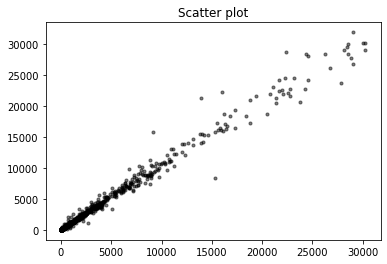

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


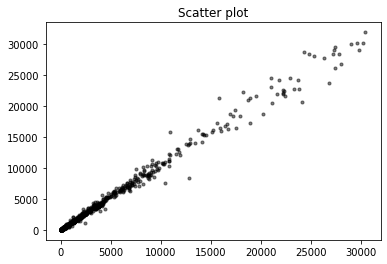

Linear Regression Metrics
Mean Absolute Error: 109.33808907739044
Mean Squared Error: 106210.0079553931
Root Mean Squared Error: 325.89876949045555
R-squared: 0.9922397601181691


In [34]:
x1 = df[['lag_sgna', 'sgna_mkt']]
y1 = df['sgna']
scatter_plot(x = x1['lag_sgna'], y = y1)
scatter_plot(x = x1['sgna_mkt'], y = y1)
x1.fillna(0,inplace=True)
print("Linear Regression Metrics")
rd=LinearReg(x1,y1)
pred=RegPredict(rd,x1,y1)

Distribution of residuals


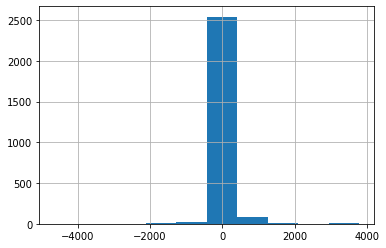

In [35]:
df['R1'] = df['sgna'] - pred
print("Distribution of residuals")
df['R1'].hist()

### Model 3: Estimate a set of models for each interaction effect

#### Defining Variables

In [36]:
DV = ['gross_profit']
IV = ['sgna', 'SQ_SGNA']
MV = ['Litigation', 'Numbers', 'developed', 'Multinational', 'Australia', 'Belgium', 'Germany', 'India', 'Ireland', 'Norway', 'Singapore', 'Sweden', 'UK', 'USA', 
      'policy_reforms_australia', 'policy_reforms_germany', 'policy_reforms_india', 'policy_reforms_NORWAY', 'policy_reforms_SINGAPORE', 'policy_reforms_SWEDEN','policy_reforms_UK',
      'policy_reforms_usa', 'GDP per capita growth (annual %)', 'Life expectancy at birth, total (years)', 'Mortality rate, infant (per 1,000 live births)', 
      'Population, total', 'Individuals using the Internet (% of population)', 'Physicians (per 1,000 people)','acquisitions']
INT_V = ['sgna_litigation', 'sgna_no_of_cases', 'sgna_developed', 'sgna_multinational',
     'sgna_Australia', 'sgna_Belgium', 'sgna_Germany', 'sgna_India', 'sgna_Ireland', 'sgna_Norway', 
     'sgna_Singapore', 'sgna_Sweden', 'sgna_UK', 'sgna_USA', 'sgna_policy_reform_Australia',
     'sgna_policy_reform_Germany', 'sgna_policy_reform_India', 'sgna_policy_reform_Norway', 'sgna_policy_reform_Singapore',
     'sgna_policy_reform_Sweden', 'sgna_policy_reform_UK', 'sgna_policy_reform_USA', 'sgna_gdp per capita growth', 'sgna_life_expectancy',
     'sgna_mortality','sgna_population', 'sgna_Individuals_using _the_Internet', 'sgna_physicians', 'sgna_acquisitions']
CV = ['current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','R1']

In [37]:
np.mean(df['gross_profit'])

2592.69788957603

In [49]:
X = df[IV + CV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Linear Regression, XGBoost and Bayesian Ridge Regression Models had the best performance in terms of MAE, RMSE and R-squared

### Linear Regression

#### Checking model without Interaction Variables and Moderating variables

Linear Regression Results - with Imputation
Mean Absolute Error: 699.24501096624
Mean Squared Error: 1158725.2876945315
Root Mean Squared Error: 1076.4410284332957
R-squared: 0.9649617555228962


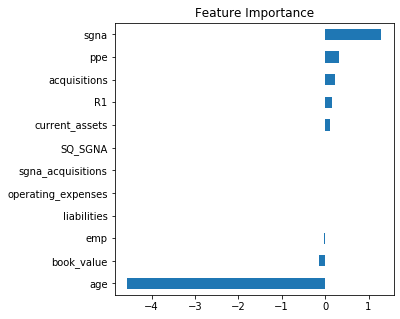

In [43]:
print("Linear Regression Results - with Imputation")
lr=LinearReg(X_train,y_train)
pred=RegPredict(lr,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(lr,index=feature_list)

#### Effect of adding each Moderating and Interacting Variable 

Effect of adding Moderating variable- Litigation and Interaction variable- sgna_litigation
Mean Absolute Error: 675.8867379653923
Mean Squared Error: 1124390.0558572437
Root Mean Squared Error: 1060.3726023701497
R-squared: 0.9660000052789592


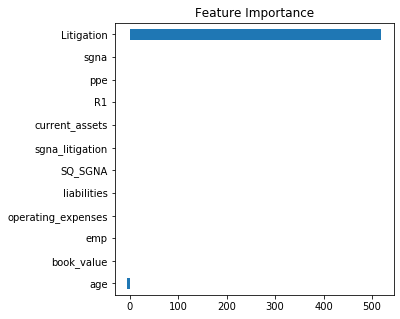

Effect of adding Moderating variable- Numbers and Interaction variable- sgna_no_of_cases
Mean Absolute Error: 687.3156165087818
Mean Squared Error: 1153378.1186268046
Root Mean Squared Error: 1073.9544304237515
R-squared: 0.9651234464940394


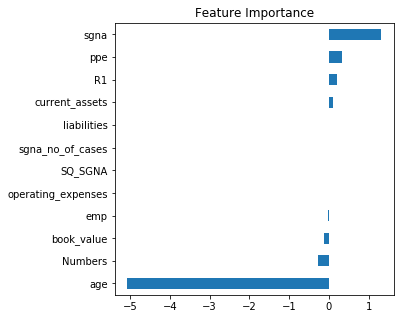

Effect of adding Moderating variable- developed and Interaction variable- sgna_developed
Mean Absolute Error: 666.0828834914049
Mean Squared Error: 1180206.212947214
Root Mean Squared Error: 1086.3729621760724
R-squared: 0.9643122021571494


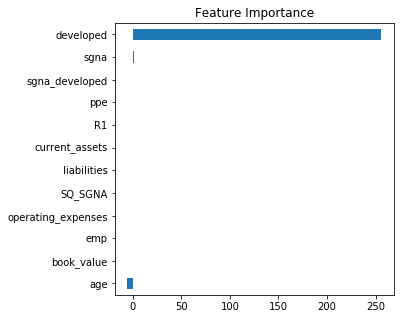

Effect of adding Moderating variable- Multinational and Interaction variable- sgna_multinational
Mean Absolute Error: 683.1422100933207
Mean Squared Error: 1162046.6649671611
Root Mean Squared Error: 1077.9826830553268
R-squared: 0.9648613216839915


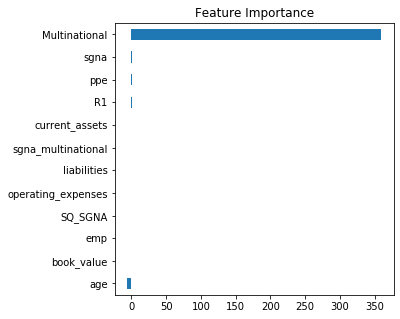

Effect of adding Moderating variable- Australia and Interaction variable- sgna_Australia
Mean Absolute Error: 680.9531267737256
Mean Squared Error: 1108200.6444508685
Root Mean Squared Error: 1052.711092584698
R-squared: 0.9664895506102134


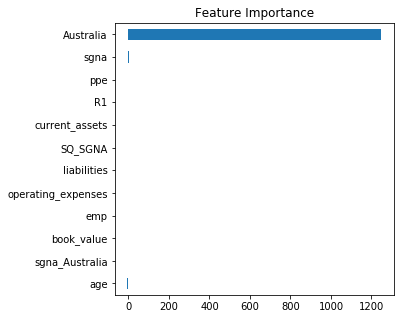

Effect of adding Moderating variable- Belgium and Interaction variable- sgna_Belgium
Mean Absolute Error: 684.1586023259987
Mean Squared Error: 1166094.1333427646
Root Mean Squared Error: 1079.8583857815638
R-squared: 0.9647389318578923


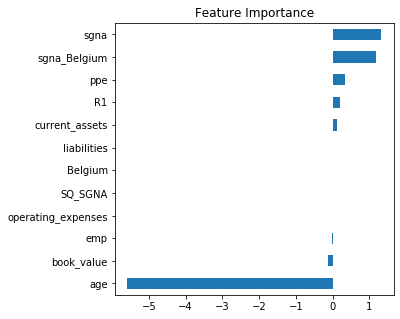

Effect of adding Moderating variable- Germany and Interaction variable- sgna_Germany
Mean Absolute Error: 689.3368274548284
Mean Squared Error: 1171983.149161305
Root Mean Squared Error: 1082.5817055360326
R-squared: 0.9645608561930468


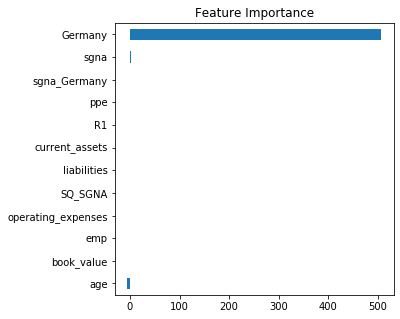

Effect of adding Moderating variable- India and Interaction variable- sgna_India
Mean Absolute Error: 666.0828834914143
Mean Squared Error: 1180206.212947234
Root Mean Squared Error: 1086.3729621760815
R-squared: 0.9643122021571489


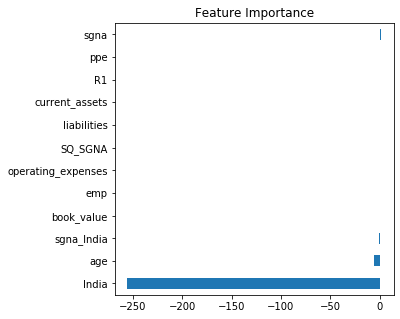

Effect of adding Moderating variable- Ireland and Interaction variable- sgna_Ireland
Mean Absolute Error: 689.7125141844086
Mean Squared Error: 1177252.1119086004
Root Mean Squared Error: 1085.0124938951626
R-squared: 0.964401530072489


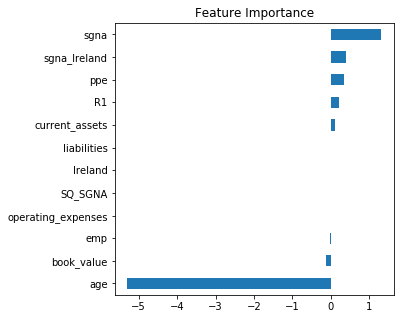

Effect of adding Moderating variable- Norway and Interaction variable- sgna_Norway
Mean Absolute Error: 696.9337601843899
Mean Squared Error: 1189339.0854474404
Root Mean Squared Error: 1090.5682397023309
R-squared: 0.9640360367684766


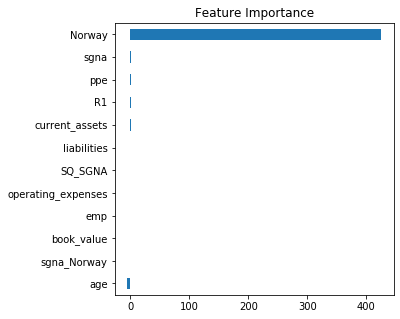

Effect of adding Moderating variable- Singapore and Interaction variable- sgna_Singapore
Mean Absolute Error: 694.9816285168145
Mean Squared Error: 1186897.6505214728
Root Mean Squared Error: 1089.4483239334818
R-squared: 0.9641098623721115


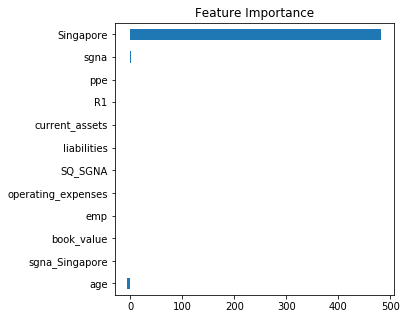

Effect of adding Moderating variable- Sweden and Interaction variable- sgna_Sweden
Mean Absolute Error: 695.3985353850899
Mean Squared Error: 1186396.036827904
Root Mean Squared Error: 1089.2180850628142
R-squared: 0.9641250304740032


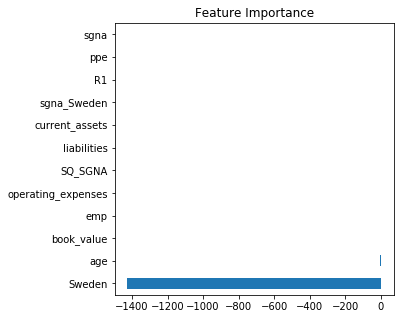

Effect of adding Moderating variable- UK and Interaction variable- sgna_UK
Mean Absolute Error: 704.2406733770893
Mean Squared Error: 1185581.5916487442
Root Mean Squared Error: 1088.8441539764744
R-squared: 0.964149658165833


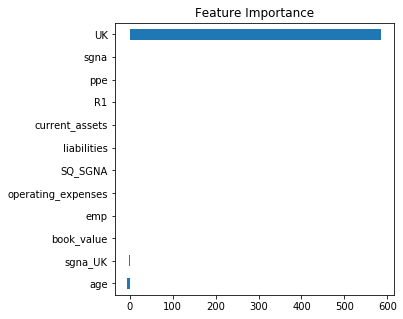

Effect of adding Moderating variable- USA and Interaction variable- sgna_USA
Mean Absolute Error: 704.838419826898
Mean Squared Error: 1169325.1246187796
Root Mean Squared Error: 1081.3533763847875
R-squared: 0.9646412311660764


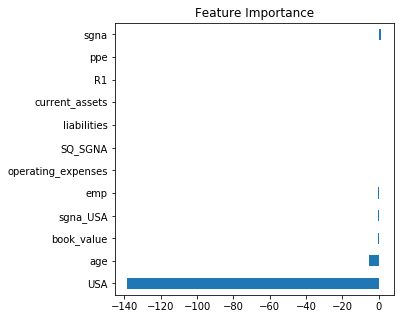

Effect of adding Moderating variable- policy_reforms_australia and Interaction variable- sgna_policy_reform_Australia
Mean Absolute Error: 680.5002755323894
Mean Squared Error: 1107144.2726356909
Root Mean Squared Error: 1052.2092342474907
R-squared: 0.9665214938277404


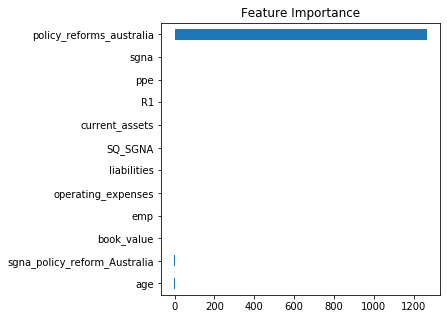

Effect of adding Moderating variable- policy_reforms_germany and Interaction variable- sgna_policy_reform_Germany
Mean Absolute Error: 691.2005634284656
Mean Squared Error: 1179140.196043219
Root Mean Squared Error: 1085.8822201524524
R-squared: 0.9643444370287757


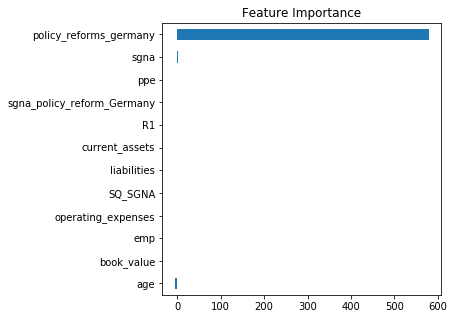

Effect of adding Moderating variable- policy_reforms_india and Interaction variable- sgna_policy_reform_India
Mean Absolute Error: 665.0818764854455
Mean Squared Error: 1179007.7565293477
Root Mean Squared Error: 1085.8212359911495
R-squared: 0.9643484418158591


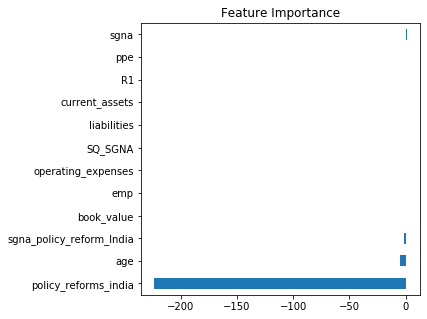

Effect of adding Moderating variable- policy_reforms_NORWAY and Interaction variable- sgna_policy_reform_Norway
Mean Absolute Error: 696.9337601843899
Mean Squared Error: 1189339.0854474404
Root Mean Squared Error: 1090.5682397023309
R-squared: 0.9640360367684766


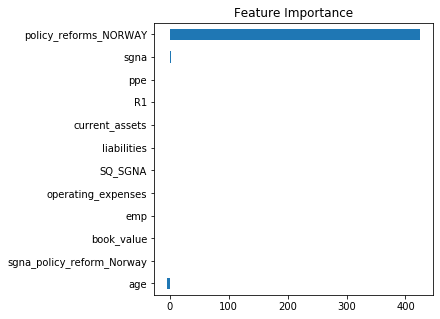

Effect of adding Moderating variable- policy_reforms_SINGAPORE and Interaction variable- sgna_policy_reform_Singapore
Mean Absolute Error: 694.9816285168145
Mean Squared Error: 1186897.6505214728
Root Mean Squared Error: 1089.4483239334818
R-squared: 0.9641098623721115


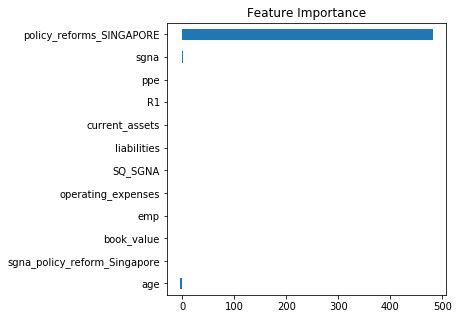

Effect of adding Moderating variable- policy_reforms_SWEDEN and Interaction variable- sgna_policy_reform_Sweden
Mean Absolute Error: 695.3985353850899
Mean Squared Error: 1186396.036827904
Root Mean Squared Error: 1089.2180850628142
R-squared: 0.9641250304740032


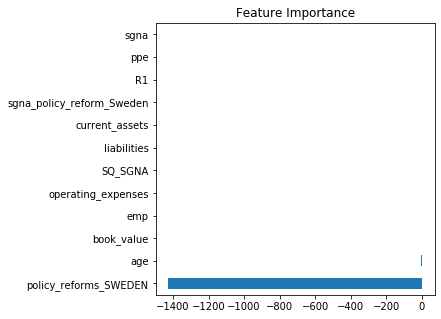

Effect of adding Moderating variable- policy_reforms_UK and Interaction variable- sgna_policy_reform_UK
Mean Absolute Error: 703.8384820267879
Mean Squared Error: 1185628.4355398035
Root Mean Squared Error: 1088.8656645977057
R-squared: 0.9641482416715831


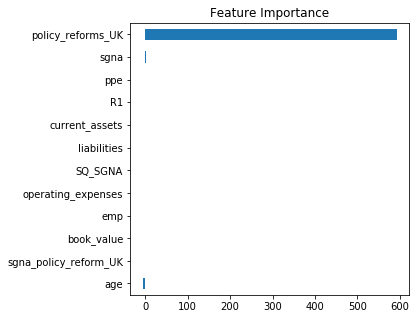

Effect of adding Moderating variable- policy_reforms_usa and Interaction variable- sgna_policy_reform_USA
Mean Absolute Error: 692.97578091944
Mean Squared Error: 1198432.3312768647
Root Mean Squared Error: 1094.7293415620431
R-squared: 0.9637610696353301


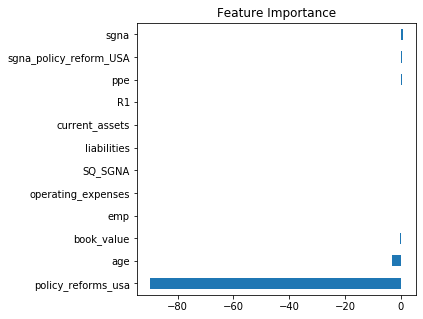

Effect of adding Moderating variable- GDP per capita growth (annual %) and Interaction variable- sgna_gdp per capita growth
Mean Absolute Error: 678.9581862645648
Mean Squared Error: 1188164.3990223706
Root Mean Squared Error: 1090.0295404356575
R-squared: 0.9640715576555952


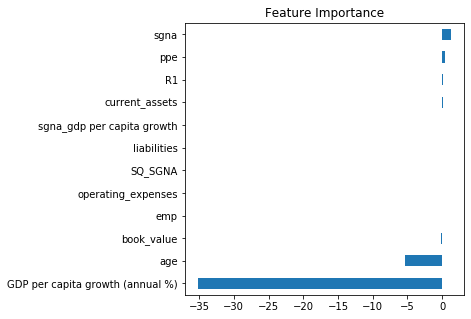

Effect of adding Moderating variable- Life expectancy at birth, total (years) and Interaction variable- sgna_life_expectancy
Mean Absolute Error: 605.3098922904195
Mean Squared Error: 1050059.301063378
Root Mean Squared Error: 1024.7240121434543
R-squared: 0.9682476641384781


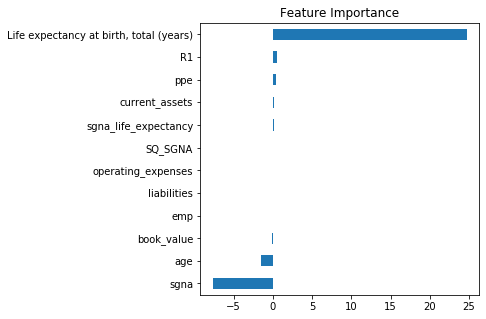

Effect of adding Moderating variable- Mortality rate, infant (per 1,000 live births) and Interaction variable- sgna_mortality
Mean Absolute Error: 634.5998785659705
Mean Squared Error: 1171373.854256749
Root Mean Squared Error: 1082.3002606748041
R-squared: 0.9645792804253054


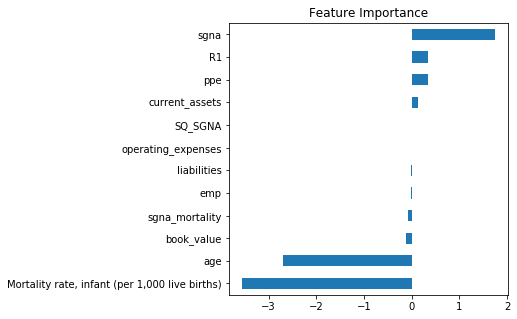

Effect of adding Moderating variable- Population, total and Interaction variable- sgna_population
Mean Absolute Error: 678.3062839147942
Mean Squared Error: 1188128.0646620116
Root Mean Squared Error: 1090.0128736221475
R-squared: 0.9640726563562231


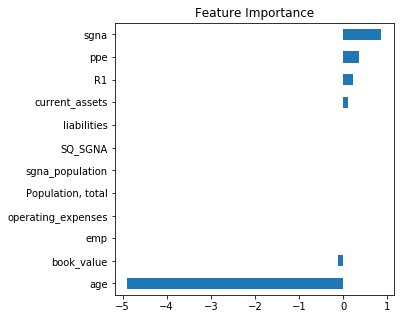

Effect of adding Moderating variable- Individuals using the Internet (% of population) and Interaction variable- sgna_Individuals_using _the_Internet
Mean Absolute Error: 690.3019207731588
Mean Squared Error: 1079277.4965276124
Root Mean Squared Error: 1038.8828117394244
R-squared: 0.9673641464602779


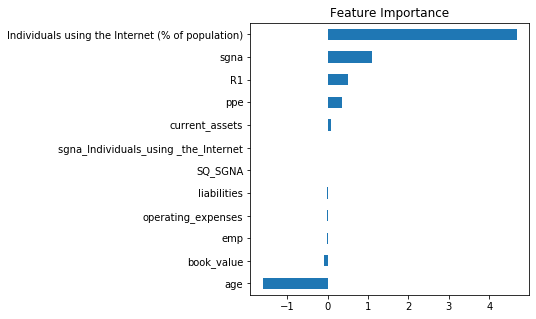

Effect of adding Moderating variable- Physicians (per 1,000 people) and Interaction variable- sgna_physicians
Mean Absolute Error: 600.6834822403396
Mean Squared Error: 1054793.9637210085
Root Mean Squared Error: 1027.031627420017
R-squared: 0.9681044945110638


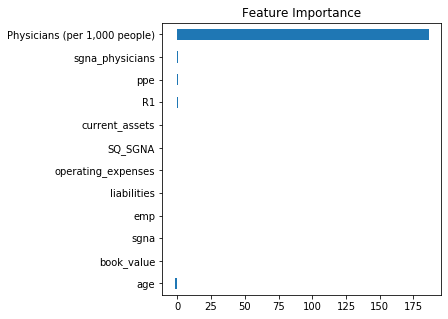

Effect of adding Moderating variable- acquisitions and Interaction variable- sgna_acquisitions
Mean Absolute Error: 699.24501096624
Mean Squared Error: 1158725.2876945315
Root Mean Squared Error: 1076.4410284332957
R-squared: 0.9649617555228962


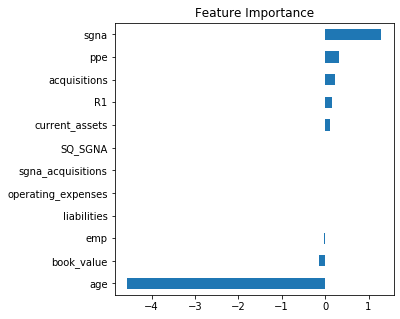

In [44]:
for i in range(0,29):
    X = df[IV+CV+[MV[i]]+[INT_V[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    lr=LinearReg(X_train,y_train)
    print("Effect of adding Moderating variable-",MV[i],"and Interaction variable-", INT_V[i])
    pred=RegPredict(lr,X_test,y_test)

    #Plotting Feature Importances 
    feature_list = list(X.columns)
    plot_feature_imp(lr,index=feature_list)    

### XGBoost Regression

#### Model without Interation and Moderating Variables

XGBoost Regression Results - With Imputation
Mean Absolute Error: 298.2356434617561
Mean Squared Error: 516468.3439400934
Root Mean Squared Error: 718.6573202438652
R-squared: 0.984382714098125


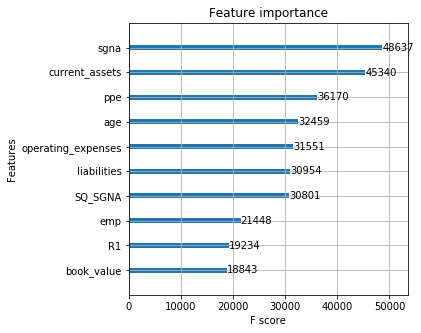

In [51]:
X = df[IV + CV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("XGBoost Regression Results - With Imputation")
xg=XGBoostReg(X_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,X_test,y_test)

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

#### Effect of adding each Moderating and Interacting Variable 

Effect of adding Moderating variable- Litigation and Interaction variable- sgna_litigation
Mean Absolute Error: 289.95641555782925
Mean Squared Error: 423081.118976382
Root Mean Squared Error: 650.446860993565
R-squared: 0.9872066141666452


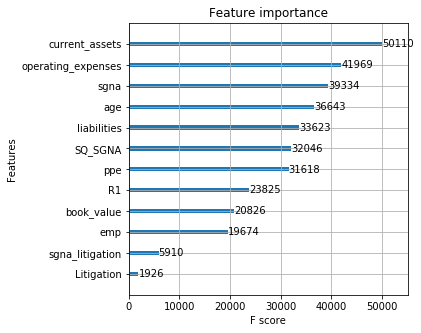

Effect of adding Moderating variable- Numbers and Interaction variable- sgna_no_of_cases
Mean Absolute Error: 320.7817584094618
Mean Squared Error: 503039.79965017637
Root Mean Squared Error: 709.2529870576341
R-squared: 0.9847887746396515


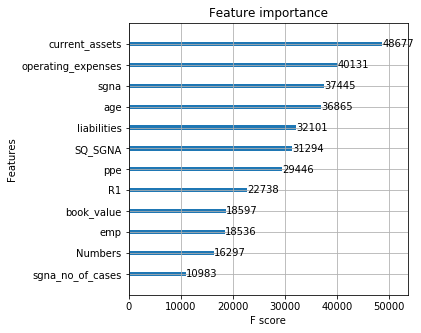

Effect of adding Moderating variable- developed and Interaction variable- sgna_developed
Mean Absolute Error: 275.4850946113983
Mean Squared Error: 367956.90494923305
Root Mean Squared Error: 606.5945144404399
R-squared: 0.9888734938905999


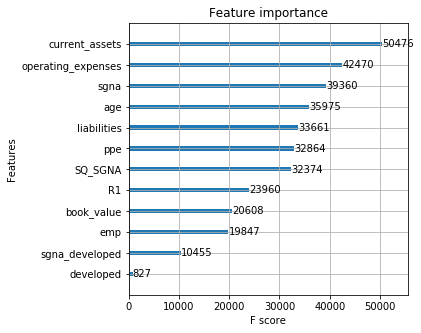

Effect of adding Moderating variable- Multinational and Interaction variable- sgna_multinational
Mean Absolute Error: 273.9352027400102
Mean Squared Error: 403960.00601217843
Root Mean Squared Error: 635.5784813948459
R-squared: 0.9877848100840289


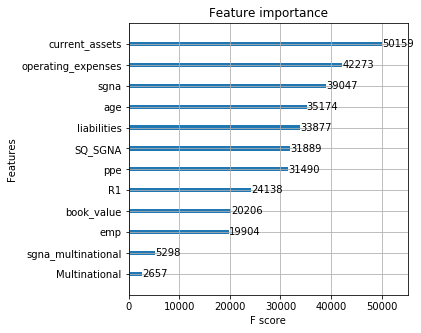

Effect of adding Moderating variable- Australia and Interaction variable- sgna_Australia
Mean Absolute Error: 315.70089495567225
Mean Squared Error: 498204.99718035583
Root Mean Squared Error: 705.8363813096884
R-squared: 0.9849349723559999


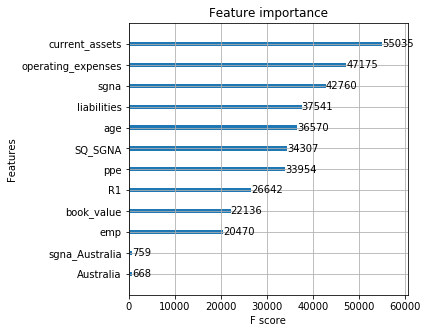

Effect of adding Moderating variable- Belgium and Interaction variable- sgna_Belgium
Mean Absolute Error: 328.02128618983556
Mean Squared Error: 515367.0867350226
Root Mean Squared Error: 717.8907206079646
R-squared: 0.9844160145875449


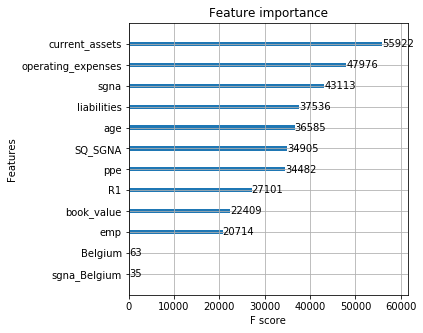

Effect of adding Moderating variable- Germany and Interaction variable- sgna_Germany
Mean Absolute Error: 326.62338411133356
Mean Squared Error: 511337.8608211017
Root Mean Squared Error: 715.0789192956968
R-squared: 0.984537852786922


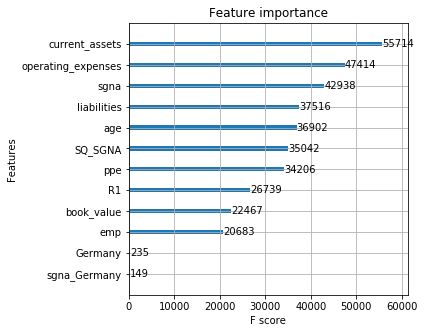

Effect of adding Moderating variable- India and Interaction variable- sgna_India
Mean Absolute Error: 325.7667515174802
Mean Squared Error: 517494.1703149966
Root Mean Squared Error: 719.3706765743212
R-squared: 0.9843516945323171


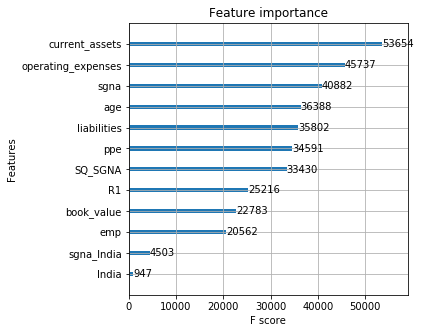

Effect of adding Moderating variable- Ireland and Interaction variable- sgna_Ireland
Mean Absolute Error: 327.5522051842553
Mean Squared Error: 528066.5144947581
Root Mean Squared Error: 726.6818523224301
R-squared: 0.9840320015179326


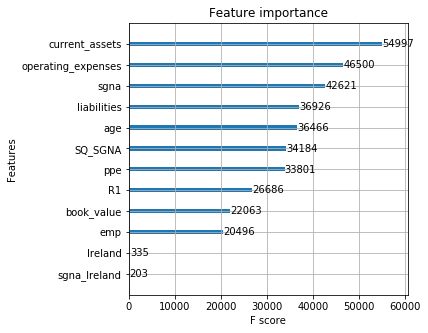

Effect of adding Moderating variable- Norway and Interaction variable- sgna_Norway
Mean Absolute Error: 328.2838522997684
Mean Squared Error: 520837.53007904266
Root Mean Squared Error: 721.690744071893
R-squared: 0.9842505959733819


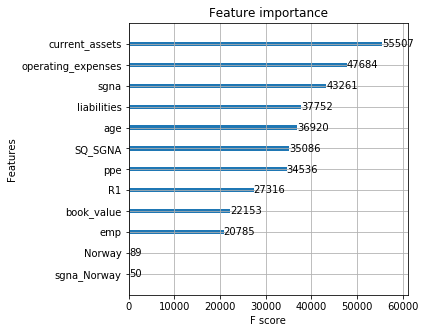

Effect of adding Moderating variable- Singapore and Interaction variable- sgna_Singapore
Mean Absolute Error: 329.4126769481634
Mean Squared Error: 516826.83132507437
Root Mean Squared Error: 718.9066916680317
R-squared: 0.9843718739371564


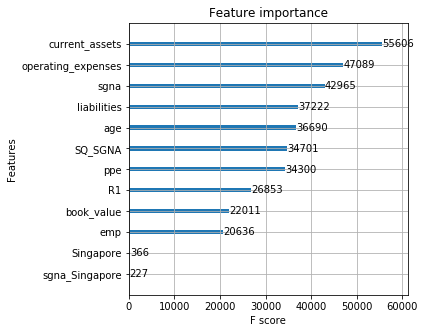

Effect of adding Moderating variable- Sweden and Interaction variable- sgna_Sweden
Mean Absolute Error: 328.0778338324926
Mean Squared Error: 515625.8887167561
Root Mean Squared Error: 718.0709496399057
R-squared: 0.9844081887748147


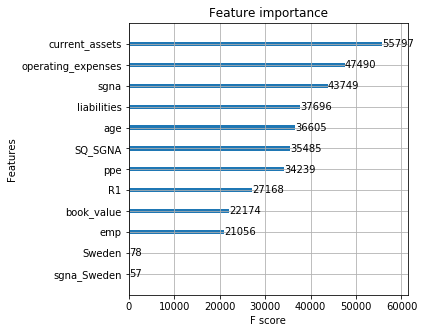

Effect of adding Moderating variable- UK and Interaction variable- sgna_UK
Mean Absolute Error: 323.4870380702756
Mean Squared Error: 518424.13588438754
Root Mean Squared Error: 720.0167608357375
R-squared: 0.9843235736642203


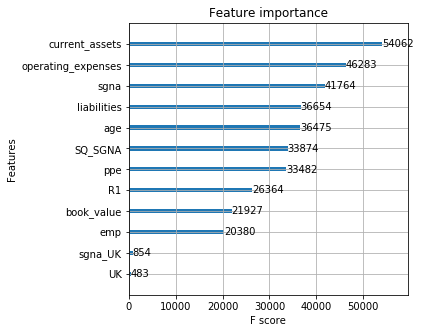

Effect of adding Moderating variable- USA and Interaction variable- sgna_USA
Mean Absolute Error: 265.59886698815774
Mean Squared Error: 357427.2549458368
Root Mean Squared Error: 597.8522015898551
R-squared: 0.9891918958923472


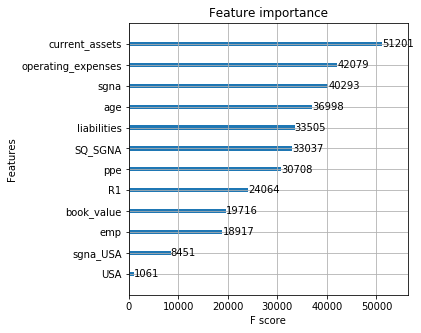

Effect of adding Moderating variable- policy_reforms_australia and Interaction variable- sgna_policy_reform_Australia
Mean Absolute Error: 316.8872406415887
Mean Squared Error: 501445.3667678409
Root Mean Squared Error: 708.128072291899
R-squared: 0.9848369880770614


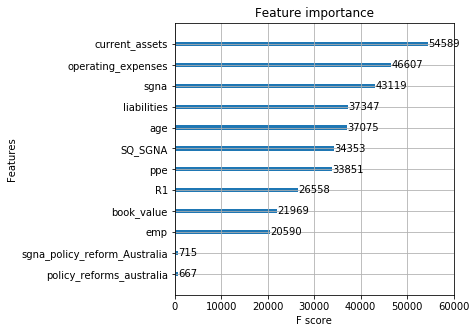

Effect of adding Moderating variable- policy_reforms_germany and Interaction variable- sgna_policy_reform_Germany
Mean Absolute Error: 325.9406421340286
Mean Squared Error: 499701.32593495544
Root Mean Squared Error: 706.895555181213
R-squared: 0.9848897254512515


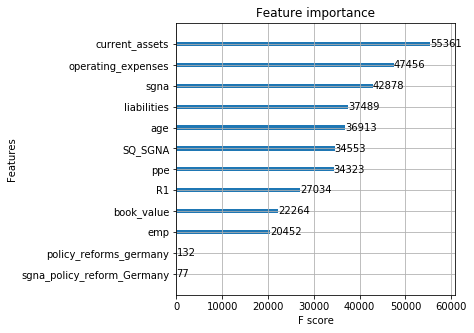

Effect of adding Moderating variable- policy_reforms_india and Interaction variable- sgna_policy_reform_India
Mean Absolute Error: 328.8269559617679
Mean Squared Error: 534914.5307994894
Root Mean Squared Error: 731.3785140400895
R-squared: 0.9838249270094045


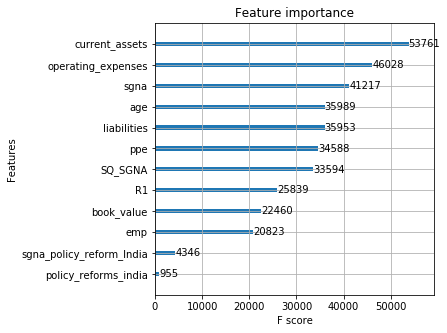

Effect of adding Moderating variable- policy_reforms_NORWAY and Interaction variable- sgna_policy_reform_Norway
Mean Absolute Error: 328.2838522997684
Mean Squared Error: 520837.53007904266
Root Mean Squared Error: 721.690744071893
R-squared: 0.9842505959733819


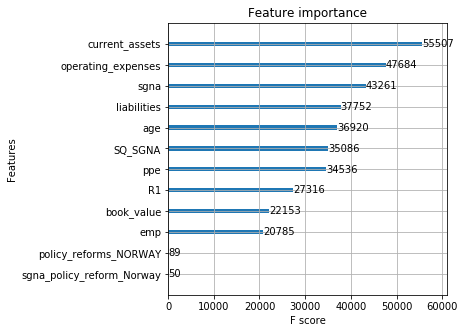

Effect of adding Moderating variable- policy_reforms_SINGAPORE and Interaction variable- sgna_policy_reform_Singapore
Mean Absolute Error: 329.4126769481634
Mean Squared Error: 516826.83132507437
Root Mean Squared Error: 718.9066916680317
R-squared: 0.9843718739371564


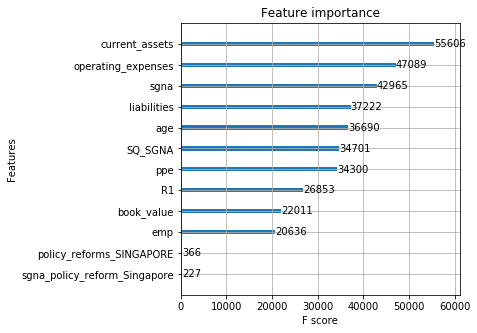

Effect of adding Moderating variable- policy_reforms_SWEDEN and Interaction variable- sgna_policy_reform_Sweden
Mean Absolute Error: 328.0778338324926
Mean Squared Error: 515625.8887167561
Root Mean Squared Error: 718.0709496399057
R-squared: 0.9844081887748147


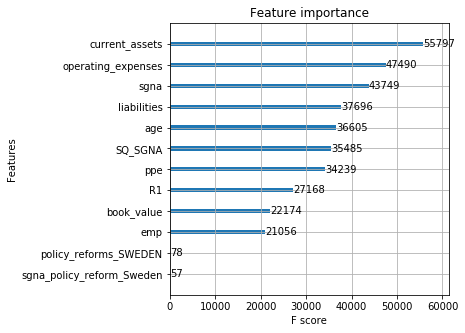

Effect of adding Moderating variable- policy_reforms_UK and Interaction variable- sgna_policy_reform_UK
Mean Absolute Error: 325.0346690301152
Mean Squared Error: 521793.6575462883
Root Mean Squared Error: 722.3528622122905
R-squared: 0.9842216840058048


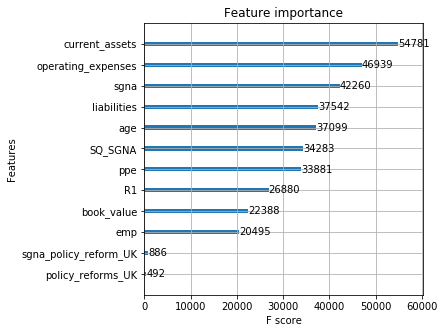

Effect of adding Moderating variable- policy_reforms_usa and Interaction variable- sgna_policy_reform_USA
Mean Absolute Error: 274.18143729629827
Mean Squared Error: 369939.70559771656
Root Mean Squared Error: 608.2266893171628
R-squared: 0.9888135367509665


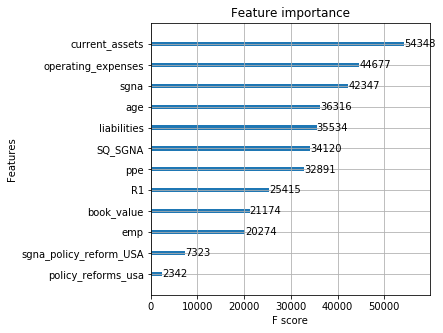

Effect of adding Moderating variable- GDP per capita growth (annual %) and Interaction variable- sgna_gdp per capita growth
Mean Absolute Error: 316.63118036973225
Mean Squared Error: 510938.2558841447
Root Mean Squared Error: 714.799451513601
R-squared: 0.9845499362855942


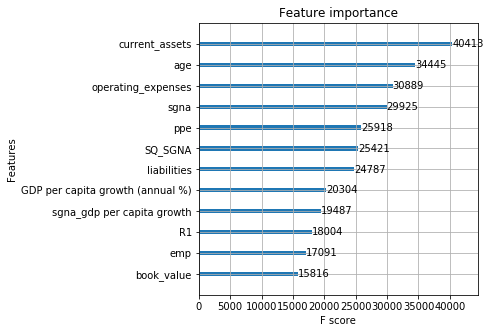

Effect of adding Moderating variable- Life expectancy at birth, total (years) and Interaction variable- sgna_life_expectancy
Mean Absolute Error: 252.72829042483184
Mean Squared Error: 351325.2529138248
Root Mean Squared Error: 592.7269632080397
R-squared: 0.9893764119646795


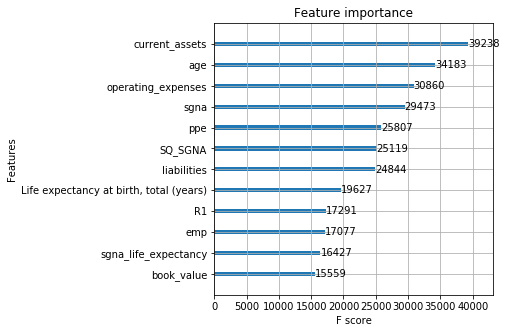

Effect of adding Moderating variable- Mortality rate, infant (per 1,000 live births) and Interaction variable- sgna_mortality
Mean Absolute Error: 264.1923887455197
Mean Squared Error: 368601.3735424755
Root Mean Squared Error: 607.1255006524397
R-squared: 0.9888540060548137


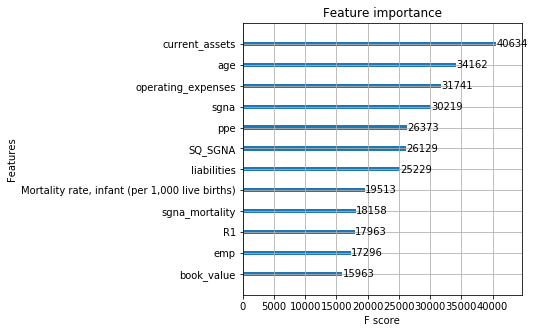

Effect of adding Moderating variable- Population, total and Interaction variable- sgna_population
Mean Absolute Error: 257.49900380288074
Mean Squared Error: 368657.51423254475
Root Mean Squared Error: 607.1717337232892
R-squared: 0.988852308438265


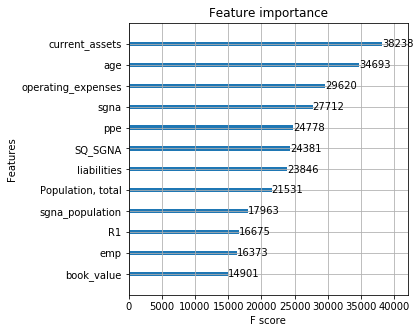

Effect of adding Moderating variable- Individuals using the Internet (% of population) and Interaction variable- sgna_Individuals_using _the_Internet
Mean Absolute Error: 264.594107583133
Mean Squared Error: 349185.47200426774
Root Mean Squared Error: 590.9191755259493
R-squared: 0.989441115969531


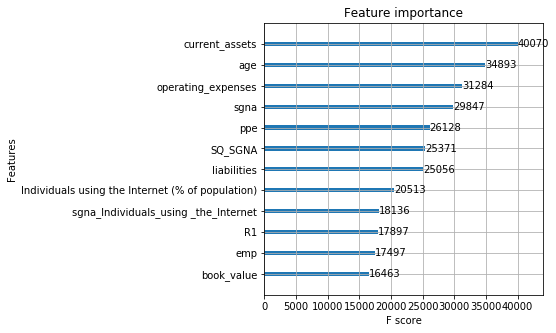

Effect of adding Moderating variable- Physicians (per 1,000 people) and Interaction variable- sgna_physicians
Mean Absolute Error: 253.07259657182001
Mean Squared Error: 340814.9451693124
Root Mean Squared Error: 583.7935809593254
R-squared: 0.9896942290833639


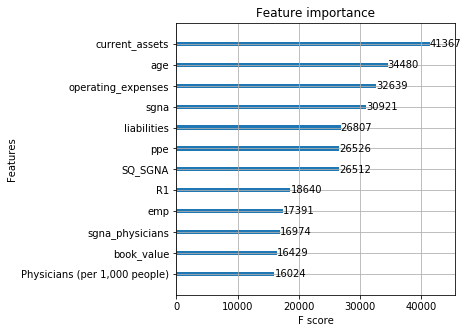

Effect of adding Moderating variable- acquisitions and Interaction variable- sgna_acquisitions
Mean Absolute Error: 297.02100875439874
Mean Squared Error: 463020.56015677634
Root Mean Squared Error: 680.4561412440748
R-squared: 0.985998900898264


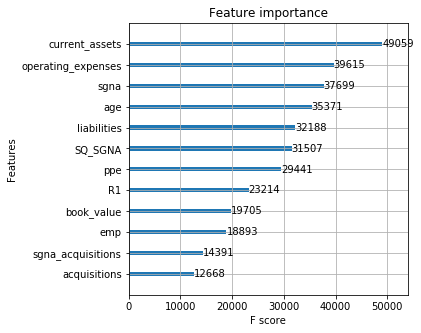

In [45]:
for i in range(0,29):
    X = df[IV+CV+[MV[i]]+[INT_V[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    xg=XGBoostReg(X_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
    print("Effect of adding Moderating variable-",MV[i],"and Interaction variable-", INT_V[i])
    pred=RegPredict(xg,X_test,y_test)

    xgb.plot_importance(xg)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()

### Bayesian Ridge Regression

#### Model without any Interaction and Moderating Variables

In [52]:
X = df[IV + CV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Bayesian Ridge Regression Results--With Imputation")
br=BayesianRidgeReg(X_train,y_train)
pred=RegPredict(br,X_test,y_test)

Bayesian Ridge Regression Results--With Imputation
Mean Absolute Error: 690.5123076572208
Mean Squared Error: 1177768.679493916
Root Mean Squared Error: 1085.2505146250408
R-squared: 0.9643859097856657


In [47]:
for i in range(0,29):
    X = df[IV+CV+[MV[i]]+[INT_V[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    br=BayesianRidgeReg(X_train,y_train)
    print("Effect of adding Moderating variable-",MV[i],"and Interaction variable-", INT_V[i])
    pred=RegPredict(br,X_test,y_test)
    print("--------------------------------------------------------------------")

Effect of adding Moderating variable- Litigation and Interaction variable- sgna_litigation
Mean Absolute Error: 679.635459693093
Mean Squared Error: 1157009.3283767253
Root Mean Squared Error: 1075.6436809542115
R-squared: 0.9650136437510454
--------------------------------------------------------------------
Effect of adding Moderating variable- Numbers and Interaction variable- sgna_no_of_cases
Mean Absolute Error: 679.4316002092429
Mean Squared Error: 1141747.1867369341
Root Mean Squared Error: 1068.5257071015812
R-squared: 0.965475149731538
--------------------------------------------------------------------
Effect of adding Moderating variable- developed and Interaction variable- sgna_developed
Mean Absolute Error: 688.1395197677584
Mean Squared Error: 1177117.067613726
Root Mean Squared Error: 1084.950260433042
R-squared: 0.9644056136245348
--------------------------------------------------------------------
Effect of adding Moderating variable- Multinational and Interaction vari

Mean Absolute Error: 687.6897567520977
Mean Squared Error: 1143368.4393820078
Root Mean Squared Error: 1069.2840779615153
R-squared: 0.9654261253017267
--------------------------------------------------------------------


### Decision Tree Regression

#### Model without any Interaction and Moderating Variables

In [53]:
X = df[IV + CV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("Decision Tree Results --Without Imputation")
dt=DecisionTreeReg(X_train,y_train,max_depth=100)
pred=RegPredict(dt,X_test,y_test)

Decision Tree Results --Without Imputation
Mean Absolute Error: 241.8407077977323
Mean Squared Error: 521725.30619433004
Root Mean Squared Error: 722.3055490540897
R-squared: 0.9842237508558216


#### Effect of adding each Moderating and Interacting Variable on the Model

In [54]:
for i in range(0,29):
    X = df[IV+CV+[MV[i]]+[INT_V[i]]]
    y = df['gross_profit'].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    dt=DecisionTreeReg(X_train,y_train,max_depth=100)
    print("Effect of adding Moderating variable-",MV[i],"and Interaction variable-", INT_V[i])
    pred=RegPredict(dt,X_test,y_test)
    print("--------------------------------------------------------------------")

Effect of adding Moderating variable- Litigation and Interaction variable- sgna_litigation
Mean Absolute Error: 265.97809206128557
Mean Squared Error: 676362.5009848976
Root Mean Squared Error: 822.4126099379178
R-squared: 0.9795477367100478
--------------------------------------------------------------------
Effect of adding Moderating variable- Numbers and Interaction variable- sgna_no_of_cases
Mean Absolute Error: 250.14433924537107
Mean Squared Error: 533366.763021004
Root Mean Squared Error: 730.3196307241125
R-squared: 0.9838717293588417
--------------------------------------------------------------------
Effect of adding Moderating variable- developed and Interaction variable- sgna_developed
Mean Absolute Error: 263.21289604239155
Mean Squared Error: 624374.1138103806
Root Mean Squared Error: 790.1734707077811
R-squared: 0.9811197933822685
--------------------------------------------------------------------
Effect of adding Moderating variable- Multinational and Interaction vari

Mean Absolute Error: 242.9252331001197
Mean Squared Error: 530939.4216250238
Root Mean Squared Error: 728.6559007000656
R-squared: 0.9839451287936904
--------------------------------------------------------------------
Effect of adding Moderating variable- acquisitions and Interaction variable- sgna_acquisitions
Mean Absolute Error: 262.0272253258849
Mean Squared Error: 495278.9059627561
Root Mean Squared Error: 703.7605458980747
R-squared: 0.9850234532932275
--------------------------------------------------------------------
